In [1]:
# import packages
import numpy as np
import pandas as pd
from datetime import datetime as dt
from operator import attrgetter
import matplotlib.colors as mcolors

from dateutil import relativedelta
from lifetimes import BetaGeoFitter, ModifiedBetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.metrics import mean_squared_error
from lifetimes.plotting import plot_period_transactions, plot_frequency_recency_matrix, plot_probability_alive_matrix

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  
import warnings
warnings.filterwarnings("ignore")


In [2]:
# import dataset
df=pd.read_csv('d14_d30_data_v3.csv',parse_dates=['first_login'], infer_datetime_format=True)
df

,first_login,d1_spend,d3_spend,d7_spend,d14_spend,d30_spend,campaign,media_source,m_1,m_2,...,sum_p_13,len_p_14,count_p_15,count_p_20,sum_p_16,sum_p_17,first_p_18,avg_p_19,sum_p_19,count_p_19
0,2021-12-18,3.779171,3.779171,3.849837,3.849837,3.849837,c_0,ms_0,Motorola,Moto E6s,...,25.85,3.0,27.0,NaN,NaN,NaN,NaN,4.060000,4.06,1.0
1,2021-12-18,0.222576,0.536247,0.536247,0.536247,0.536247,c_1,ms_0,OPPO,CPH2127,...,NaN,NaN,19.0,2.0,NaN,NaN,NaN,2.000000,2.00,1.0
2,2021-06-11,0.049088,0.049088,0.049088,0.049088,0.049088,c_2,ms_1,Vivo,1907,...,NaN,NaN,37.0,NaN,NaN,NaN,NaN,6.928000,34.64,5.0
3,2021-08-17,NaN,NaN,NaN,NaN,0.761715,c_1,ms_0,Lenovo,TB-X606V,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,5.000000,5.00,1.0
4,2021-08-10,0.377731,0.377731,0.377731,0.377731,0.377731,c_3,ms_1,OPPO,CPH2127,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,2.390000,2.39,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292284,2021-10-01,0.048490,0.048490,0.048490,0.048490,0.048490,c_1,ms_0,Samsung,SM-J700F,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.000000,4.00,1.0
292285,2021-12-03,0.299588,0.299588,0.299588,0.299588,0.299588,c_0,ms_0,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.000000,2.00,1.0
292286,2021-12-03,NaN,NaN,79.165510,118.631176,119.051301,c_60,ms_1,Vivo,Vivo 2015,...,NaN,NaN,85.0,NaN,0.0,143.0,NaN,25.777778,232.00,9.0
292287,2021-02-06,0.641836,0.641836,0.641836,0.641836,0.641836,c_5,ms_1,OPPO,CPH2015,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2.480000,2.48,1.0


In [3]:
# Display a summary of the dataset
df.describe()

,d1_spend,d3_spend,d7_spend,d14_spend,d30_spend,m_3,m_4,avg_p_1,count_p_1,max_p_2,...,sum_p_13,len_p_14,count_p_15,count_p_20,sum_p_16,sum_p_17,first_p_18,avg_p_19,sum_p_19,count_p_19
count,256486.000000,271707.000000,279184.000000,286268.000000,292289.000000,215059.000000,215059.000000,245319.000000,286268.000000,2.862680e+05,...,22308.000000,16540.000000,287843.000000,87303.000000,38345.000000,38345.000000,21806.000000,290342.000000,290342.000000,290556.000000
mean,7.456764,17.129920,34.567858,59.220231,109.085933,0.073175,0.073175,54.641701,42.997534,1.000000e-02,...,2785.393638,6.870496,21.051195,29.847382,41.039640,278.324371,0.882464,7.524501,42.935510,2.498217
std,107.605254,289.528166,670.886965,1231.009770,2416.610713,0.260425,0.260425,21.336486,217.744751,5.611840e-14,...,13121.029436,10.568188,60.207410,60.192379,211.470487,2182.467152,0.322066,17.464098,257.516237,33.301261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-02,...,5.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.092917,0.100000,0.000000
25%,0.037647,0.039343,0.040000,0.040000,0.040000,0.000000,0.000000,41.354356,1.000000,1.000000e-02,...,50.000000,1.000000,3.000000,1.000000,0.000000,4.000000,1.000000,2.000000,2.000000,1.000000
50%,0.100000,0.105000,0.106277,0.107446,0.108182,0.000000,0.000000,54.666667,4.000000,1.000000e-02,...,244.000000,3.000000,7.000000,4.000000,0.000000,16.000000,1.000000,2.610000,2.640000,1.000000
75%,0.415225,0.502560,0.557373,0.590028,0.611727,0.000000,0.000000,67.000000,12.000000,1.000000e-02,...,1250.500000,8.000000,16.000000,45.000000,0.000000,77.000000,1.000000,7.000000,14.000000,2.000000
max,12190.426420,33917.771250,83448.123450,191061.871200,457674.703500,1.000000,1.000000,237.400360,8825.000000,1.000000e-02,...,511192.500000,163.000000,3769.000000,3281.000000,6095.000000,119862.000000,1.000000,1330.000000,38988.000000,8319.000000


In [4]:
# Display the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292289 entries, 0 to 292288
Data columns (total 46 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   first_login   292289 non-null  datetime64[ns]
 1   d1_spend      256486 non-null  float64       
 2   d3_spend      271707 non-null  float64       
 3   d7_spend      279184 non-null  float64       
 4   d14_spend     286268 non-null  float64       
 5   d30_spend     292289 non-null  float64       
 6   campaign      292289 non-null  object        
 7   media_source  292289 non-null  object        
 8   m_1           275911 non-null  object        
 9   m_2           275910 non-null  object        
 10  u_1           278947 non-null  object        
 11  u_3           290105 non-null  object        
 12  u_4           255609 non-null  object        
 13  u_2           279386 non-null  object        
 14  m_3           215059 non-null  float64       
 15  m_4           215

# Data Cleaning

In [5]:
# Add ID for each users
df['id'] = range(1,len(df)+1)

# extract columns to bulid a new dataset
df_a = df[['id','first_login','d1_spend','d3_spend','d7_spend','d14_spend','d30_spend']]
df_a = df_a.fillna(0)
df_a


,id,first_login,d1_spend,d3_spend,d7_spend,d14_spend,d30_spend
0,1,2021-12-18,3.779171,3.779171,3.849837,3.849837,3.849837
1,2,2021-12-18,0.222576,0.536247,0.536247,0.536247,0.536247
2,3,2021-06-11,0.049088,0.049088,0.049088,0.049088,0.049088
3,4,2021-08-17,0.000000,0.000000,0.000000,0.000000,0.761715
4,5,2021-08-10,0.377731,0.377731,0.377731,0.377731,0.377731
...,...,...,...,...,...,...,...
292284,292285,2021-10-01,0.048490,0.048490,0.048490,0.048490,0.048490
292285,292286,2021-12-03,0.299588,0.299588,0.299588,0.299588,0.299588
292286,292287,2021-12-03,0.000000,0.000000,79.165510,118.631176,119.051301
292287,292288,2021-02-06,0.641836,0.641836,0.641836,0.641836,0.641836


In [6]:
# Calculate the spend amount for each day
df_a['d3_1'] = df_a['d3_spend'] - df_a['d1_spend']
df_a['d7_3'] = df_a['d7_spend'] - df_a['d3_spend']
df_a['d14_7'] = df_a['d14_spend'] - df_a['d7_spend']
df_a['d30_14'] = df_a['d30_spend'] - df_a['d14_spend']
df_a.head(10)

,id,first_login,d1_spend,d3_spend,d7_spend,d14_spend,d30_spend,d3_1,d7_3,d14_7,d30_14
0,1,2021-12-18,3.779171,3.779171,3.849837,3.849837,3.849837,0.000000,0.070667,0.000000,0.000000
1,2,2021-12-18,0.222576,0.536247,0.536247,0.536247,0.536247,0.313671,0.000000,0.000000,0.000000
2,3,2021-06-11,0.049088,0.049088,0.049088,0.049088,0.049088,0.000000,0.000000,0.000000,0.000000
3,4,2021-08-17,0.000000,0.000000,0.000000,0.000000,0.761715,0.000000,0.000000,0.000000,0.761715
4,5,2021-08-10,0.377731,0.377731,0.377731,0.377731,0.377731,0.000000,0.000000,0.000000,0.000000
5,6,2022-02-04,2.082495,2.082495,2.082495,2.082495,2.082495,0.000000,0.000000,0.000000,0.000000
6,7,2021-06-13,0.013333,0.013333,0.013333,0.013333,0.013333,0.000000,0.000000,0.000000,0.000000
7,8,2021-06-13,0.000000,0.000000,0.000000,0.000000,0.092826,0.000000,0.000000,0.000000,0.092826
8,9,2021-10-07,0.102332,0.102332,0.102332,0.102332,0.102332,0.000000,0.000000,0.000000,0.000000
9,10,2021-10-07,0.000000,0.000000,0.000000,0.106469,0.106469,0.000000,0.000000,0.106469,0.000000


In [20]:
# extract columns to bulid a new dataset
df_d = df_a[['id','first_login','d1_spend','d3_1','d7_3','d14_7','d30_14']]
df_d.head(10)

,id,first_login,d1_spend,d3_1,d7_3,d14_7,d30_14
0,1,2021-12-18,3.779171,0.000000,0.070667,0.000000,0.000000
1,2,2021-12-18,0.222576,0.313671,0.000000,0.000000,0.000000
2,3,2021-06-11,0.049088,0.000000,0.000000,0.000000,0.000000
3,4,2021-08-17,0.000000,0.000000,0.000000,0.000000,0.761715
4,5,2021-08-10,0.377731,0.000000,0.000000,0.000000,0.000000
5,6,2022-02-04,2.082495,0.000000,0.000000,0.000000,0.000000
6,7,2021-06-13,0.013333,0.000000,0.000000,0.000000,0.000000
7,8,2021-06-13,0.000000,0.000000,0.000000,0.000000,0.092826
8,9,2021-10-07,0.102332,0.000000,0.000000,0.000000,0.000000
9,10,2021-10-07,0.000000,0.000000,0.000000,0.106469,0.000000


In [21]:
# Calculate the total spend amount for each user
df_d['sum'] = df_d['d1_spend'] + df_d['d3_1'] + df_d['d7_3'] + df_d['d14_7']+ df_d['d30_14']
df_d

,id,first_login,d1_spend,d3_1,d7_3,d14_7,d30_14,sum
0,1,2021-12-18,3.779171,0.000000,0.070667,0.000000,0.000000,3.849837
1,2,2021-12-18,0.222576,0.313671,0.000000,0.000000,0.000000,0.536247
2,3,2021-06-11,0.049088,0.000000,0.000000,0.000000,0.000000,0.049088
3,4,2021-08-17,0.000000,0.000000,0.000000,0.000000,0.761715,0.761715
4,5,2021-08-10,0.377731,0.000000,0.000000,0.000000,0.000000,0.377731
...,...,...,...,...,...,...,...,...
292284,292285,2021-10-01,0.048490,0.000000,0.000000,0.000000,0.000000,0.048490
292285,292286,2021-12-03,0.299588,0.000000,0.000000,0.000000,0.000000,0.299588
292286,292287,2021-12-03,0.000000,0.000000,79.165510,39.465666,0.420125,119.051301
292287,292288,2021-02-06,0.641836,0.000000,0.000000,0.000000,0.000000,0.641836


In [22]:
# change the type of column login_month
df_d['login_month'] = df_d['first_login'].dt.to_period('M')
df_d

,id,first_login,d1_spend,d3_1,d7_3,d14_7,d30_14,sum,login_month
0,1,2021-12-18,3.779171,0.000000,0.070667,0.000000,0.000000,3.849837,2021-12
1,2,2021-12-18,0.222576,0.313671,0.000000,0.000000,0.000000,0.536247,2021-12
2,3,2021-06-11,0.049088,0.000000,0.000000,0.000000,0.000000,0.049088,2021-06
3,4,2021-08-17,0.000000,0.000000,0.000000,0.000000,0.761715,0.761715,2021-08
4,5,2021-08-10,0.377731,0.000000,0.000000,0.000000,0.000000,0.377731,2021-08
...,...,...,...,...,...,...,...,...,...
292284,292285,2021-10-01,0.048490,0.000000,0.000000,0.000000,0.000000,0.048490,2021-10
292285,292286,2021-12-03,0.299588,0.000000,0.000000,0.000000,0.000000,0.299588,2021-12
292286,292287,2021-12-03,0.000000,0.000000,79.165510,39.465666,0.420125,119.051301,2021-12
292287,292288,2021-02-06,0.641836,0.000000,0.000000,0.000000,0.000000,0.641836,2021-02


In [23]:
# extract columns to bulid a new dataset
df_d1 = df_d[['id','sum','login_month']]
df_d1.head(10)

,id,sum,login_month
0,1,3.849837,2021-12
1,2,0.536247,2021-12
2,3,0.049088,2021-06
3,4,0.761715,2021-08
4,5,0.377731,2021-08
5,6,2.082495,2022-02
6,7,0.013333,2021-06
7,8,0.092826,2021-06
8,9,0.102332,2021-10
9,10,0.106469,2021-10


In [24]:
# Calculate the total spend amount for each month
df_d2 = df_d1.groupby('login_month')['sum'].sum()
df_d2

login_month
2020-08    1.995594e+05
2020-09    8.349166e+05
2020-10    1.039487e+06
2020-11    3.099575e+06
2020-12    1.811215e+06
2021-01    2.769155e+06
2021-02    1.717972e+06
2021-03    1.599434e+06
2021-04    1.374137e+06
2021-05    2.375858e+06
2021-06    1.359590e+06
2021-07    1.432194e+06
2021-08    2.193145e+06
2021-09    1.848946e+06
2021-10    1.370934e+06
2021-11    1.111243e+06
2021-12    1.711236e+06
2022-01    1.403720e+06
2022-02    1.577303e+06
2022-03    4.947856e+05
2022-04    2.297383e+05
2022-05    1.239592e+05
2022-06    8.974715e+04
2022-07    1.167660e+05
Freq: M, Name: sum, dtype: float64

In [25]:
# Find the min/median/max spend amount
print(df_d2.min())
print(df_d2.median())
print(df_d2.max())

89747.147300443
1388928.787670901
3099575.184164391


In [26]:
df_d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292289 entries, 0 to 292288
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype    
---  ------       --------------   -----    
 0   id           292289 non-null  int64    
 1   sum          292289 non-null  float64  
 2   login_month  292289 non-null  period[M]
dtypes: float64(1), int64(1), period[M](1)
memory usage: 6.7 MB


# retention rate

In [28]:
# copy df_c as a new dataset
df_e = df_c.copy()

In [29]:
# only remain data that Spend is not equal to 0
df_e = df_e[df_e['Spend'] != 0]

In [30]:
# choose data of June 2022
df_e['Day'] = pd.to_datetime(df_e['Day'], format="%Y/%m/%d")

open_day1='2022-06-01'

close_day1='2022-06-30'

con1=df_e['Day']>=open_day1

con2=df_e['Day']<=close_day1

df_e1=df_e[con1&con2]

In [31]:
df_e1.head(10)

,Id,Day,Spend
640,129,2022-06-27,0.075000
645,130,2022-06-27,45.101778
1075,216,2022-06-05,0.015000
1495,300,2022-06-04,0.023087
1500,301,2022-06-04,0.088268
1735,348,2022-06-04,0.047632
2005,402,2022-06-05,0.110000
2010,403,2022-06-05,0.015000
2495,500,2022-06-04,0.050000
3115,624,2022-06-04,0.050000


In [32]:
# Get the cohort for each user 
df_e1['order_day'] = df_e1['Day'].dt.to_period('D')
df_e1['cohort'] = df_e1.groupby('Id')['Day'].transform('min') \
                 .dt.to_period('D') 
df_e1

,Id,Day,Spend,order_day,cohort
640,129,2022-06-27,0.075000,2022-06-27,2022-06-27
645,130,2022-06-27,45.101778,2022-06-27,2022-06-27
1075,216,2022-06-05,0.015000,2022-06-05,2022-06-05
1495,300,2022-06-04,0.023087,2022-06-04,2022-06-04
1500,301,2022-06-04,0.088268,2022-06-04,2022-06-04
...,...,...,...,...,...
1460070,292015,2022-06-08,0.023000,2022-06-08,2022-06-08
1460080,292017,2022-06-09,0.010000,2022-06-09,2022-06-09
1460325,292066,2022-06-08,0.157980,2022-06-08,2022-06-08
1460750,292151,2022-06-08,0.010000,2022-06-08,2022-06-08


In [33]:
# Get the customer_number and period_number for each day
df_e1_cohort = df_e1.groupby(['cohort', 'order_day'])['Id'].nunique().reset_index()

df_e1_cohort.columns=['cohort', 'order_day', 'customer_number']
df_e1_cohort['period_number'] = (df_e1_cohort.order_day - df_e1_cohort.cohort).apply(attrgetter('n'))
df_e1_cohort

,cohort,order_day,customer_number,period_number
0,2022-06-01,2022-06-01,481,0
1,2022-06-01,2022-06-03,12,2
2,2022-06-01,2022-06-05,2,4
3,2022-06-01,2022-06-07,5,6
4,2022-06-01,2022-06-08,2,7
...,...,...,...,...
123,2022-06-27,2022-06-29,5,2
124,2022-06-28,2022-06-28,38,0
125,2022-06-28,2022-06-30,3,2
126,2022-06-29,2022-06-29,34,0


<AxesSubplot:xlabel='period_number', ylabel='customer_number'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


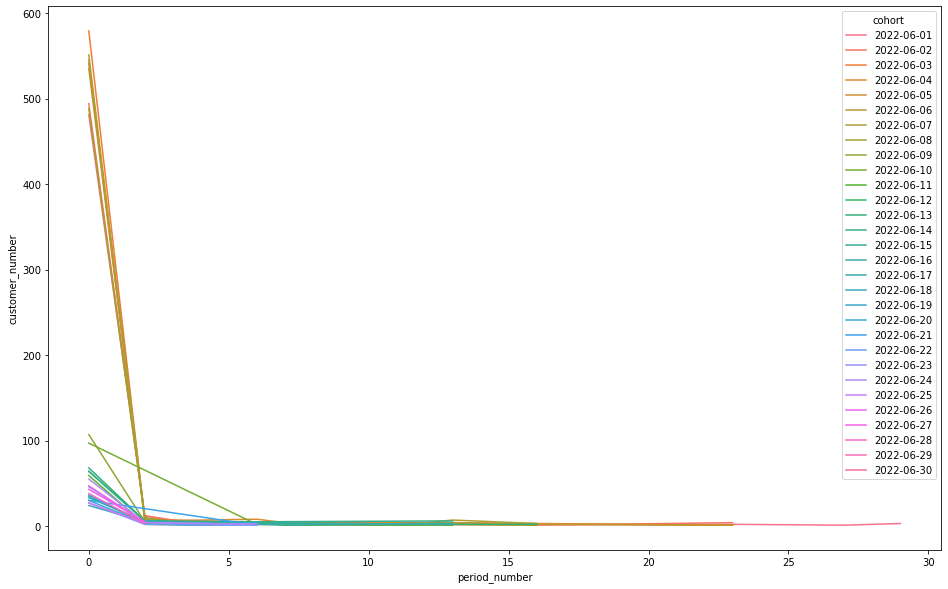

In [34]:
# Draw the line plot between customer_number and period_number
plt.subplots(figsize=(16,10))
sns.lineplot(data=df_e1_cohort,x='period_number',y='customer_number',hue='cohort')

In [35]:
# Build the pivot table for each cohort
cohort_pivot = df_e1_cohort.pivot_table(index = 'cohort',
                                       columns = 'period_number',
                                       values = 'customer_number')
cohort_pivot

period_number,0,2,4,6,7,11,13,16,23,27,29
cohort,,,,,,,,,,,
2022-06-01,481.0,12.0,2.0,5.0,2.0,1.0,2.0,NaN,2.0,1.0,3.0
2022-06-02,494.0,12.0,1.0,4.0,5.0,1.0,3.0,1.0,4.0,NaN,NaN
2022-06-03,579.0,8.0,NaN,4.0,2.0,NaN,2.0,2.0,1.0,NaN,NaN
2022-06-04,545.0,6.0,NaN,8.0,4.0,NaN,4.0,3.0,1.0,NaN,NaN
2022-06-05,535.0,7.0,NaN,3.0,3.0,NaN,NaN,1.0,NaN,NaN,NaN
2022-06-06,541.0,7.0,1.0,5.0,1.0,NaN,4.0,2.0,1.0,NaN,NaN
2022-06-07,551.0,10.0,1.0,5.0,NaN,1.0,7.0,3.0,NaN,NaN,NaN
2022-06-08,488.0,9.0,1.0,3.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN
2022-06-09,107.0,5.0,2.0,2.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN


In [36]:
# Calculate the cohort size
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0) 

cohort_size

cohort
2022-06-01    481.0
2022-06-02    494.0
2022-06-03    579.0
2022-06-04    545.0
2022-06-05    535.0
2022-06-06    541.0
2022-06-07    551.0
2022-06-08    488.0
2022-06-09    107.0
2022-06-10     97.0
2022-06-11     59.0
2022-06-12     64.0
2022-06-13     68.0
2022-06-14     64.0
2022-06-15     35.0
2022-06-16     28.0
2022-06-17     33.0
2022-06-18     24.0
2022-06-19     36.0
2022-06-20     30.0
2022-06-21     30.0
2022-06-22     27.0
2022-06-23     46.0
2022-06-24     55.0
2022-06-25     27.0
2022-06-26     47.0
2022-06-27     43.0
2022-06-28     38.0
2022-06-29     34.0
2022-06-30     44.0
Freq: D, Name: 0, dtype: float64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


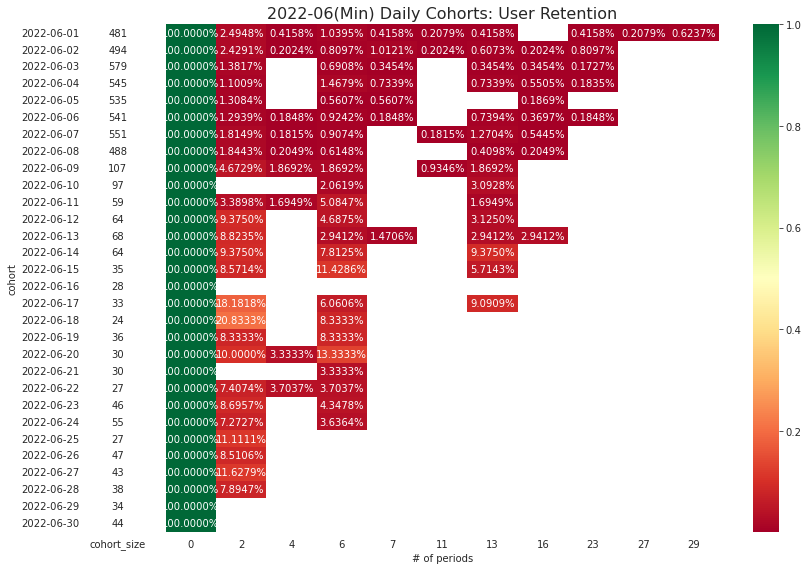

In [37]:
# visualize the retention rate
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.4%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('2022-06(Min) Daily Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [53]:
# choose data of October 2021
df_e['Day'] = pd.to_datetime(df_e['Day'], format="%Y/%m/%d")

open_day2='2021-10-01'

close_day2='2021-10-31'

con3=df_e['Day']>=open_day2

con4=df_e['Day']<=close_day2

df_e2=df_e[con3&con4]

In [54]:
# Get the cohort for each user 
df_e2['order_day'] = df_e2['Day'].dt.to_period('D')
df_e2['cohort'] = df_e2.groupby('Id')['Day'].transform('min') \
                 .dt.to_period('D') 
df_e2

,Id,Day,Spend,order_day,cohort
40,9,2021-10-07,0.102332,2021-10-07,2021-10-07
48,10,2021-10-20,0.106469,2021-10-20,2021-10-20
105,22,2021-10-10,0.195251,2021-10-10,2021-10-10
110,23,2021-10-10,0.205000,2021-10-10,2021-10-10
370,75,2021-10-25,52.510000,2021-10-25,2021-10-25
...,...,...,...,...,...
1461260,292253,2021-10-04,0.087465,2021-10-04,2021-10-04
1461263,292253,2021-10-17,0.060413,2021-10-17,2021-10-04
1461265,292254,2021-10-04,0.065000,2021-10-04,2021-10-04
1461266,292254,2021-10-06,0.240218,2021-10-06,2021-10-04


In [55]:
# Get the customer_number and period_number for each day
df_e2_cohort = df_e2.groupby(['cohort', 'order_day'])['Id'].nunique().reset_index()

df_e2_cohort.columns=['cohort', 'order_day', 'customer_number']
df_e2_cohort['period_number'] = (df_e2_cohort.order_day - df_e2_cohort.cohort).apply(attrgetter('n'))
df_e2_cohort

,cohort,order_day,customer_number,period_number
0,2021-10-01,2021-10-01,564,0
1,2021-10-01,2021-10-03,40,2
2,2021-10-01,2021-10-05,26,4
3,2021-10-01,2021-10-07,28,6
4,2021-10-01,2021-10-08,19,7
...,...,...,...,...
186,2021-10-28,2021-10-30,51,2
187,2021-10-29,2021-10-29,410,0
188,2021-10-29,2021-10-31,40,2
189,2021-10-30,2021-10-30,436,0


<AxesSubplot:xlabel='period_number', ylabel='customer_number'>

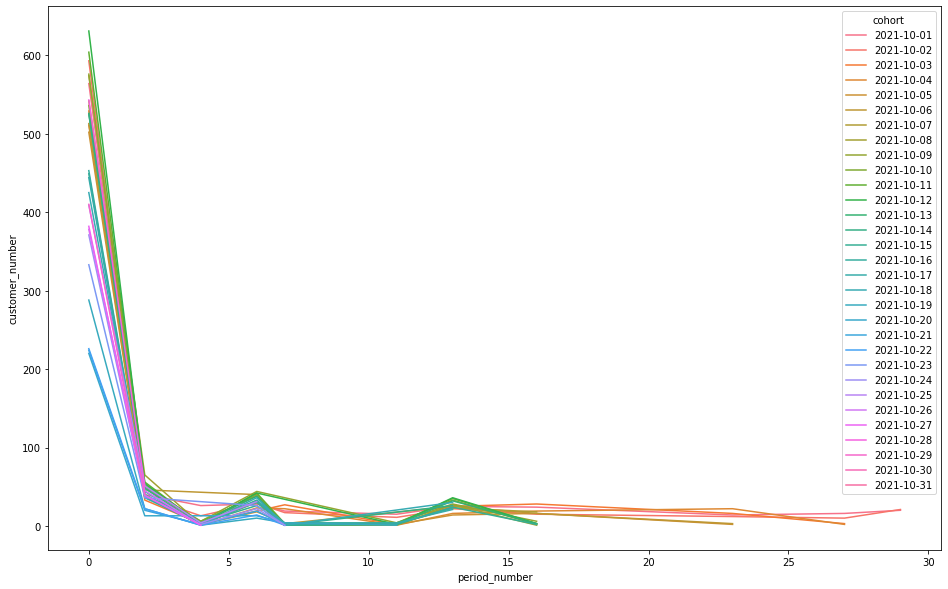

In [56]:
# Draw the line plot between customer_number and period_number
plt.subplots(figsize=(16,10))
sns.lineplot(data=df_e2_cohort,x='period_number',y='customer_number',hue='cohort')

In [57]:
# Build the pivot table for each cohort
cohort_pivot = df_e2_cohort.pivot_table(index = 'cohort',
                                       columns = 'period_number',
                                       values = 'customer_number')
cohort_pivot

period_number,0,2,4,6,7,11,13,16,23,27,29
cohort,,,,,,,,,,,
2021-10-01,564.0,40.0,26.0,28.0,19.0,15.0,25.0,24.0,14.0,16.0,20.0
2021-10-02,593.0,37.0,13.0,29.0,17.0,11.0,22.0,15.0,12.0,10.0,21.0
2021-10-03,529.0,33.0,3.0,19.0,27.0,2.0,25.0,28.0,16.0,3.0,NaN
2021-10-04,511.0,39.0,1.0,23.0,22.0,1.0,16.0,19.0,22.0,2.0,NaN
2021-10-05,502.0,37.0,2.0,18.0,4.0,2.0,14.0,16.0,2.0,NaN,NaN
2021-10-06,513.0,46.0,NaN,40.0,3.0,NaN,25.0,16.0,3.0,NaN,NaN
2021-10-07,542.0,52.0,2.0,30.0,1.0,2.0,23.0,18.0,NaN,NaN,NaN
2021-10-08,574.0,65.0,2.0,40.0,1.0,1.0,27.0,1.0,NaN,NaN,NaN
2021-10-09,576.0,48.0,6.0,44.0,NaN,4.0,28.0,6.0,NaN,NaN,NaN


In [58]:
# Calculate the cohort size
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0) 

cohort_size

cohort
2021-10-01    564.0
2021-10-02    593.0
2021-10-03    529.0
2021-10-04    511.0
2021-10-05    502.0
2021-10-06    513.0
2021-10-07    542.0
2021-10-08    574.0
2021-10-09    576.0
2021-10-10    536.0
2021-10-11    604.0
2021-10-12    631.0
2021-10-13    526.0
2021-10-14    525.0
2021-10-15    449.0
2021-10-16    453.0
2021-10-17    444.0
2021-10-18    425.0
2021-10-19    288.0
2021-10-20    220.0
2021-10-21    224.0
2021-10-22    226.0
2021-10-23    333.0
2021-10-24    371.0
2021-10-25    409.0
2021-10-26    378.0
2021-10-27    382.0
2021-10-28    543.0
2021-10-29    410.0
2021-10-30    436.0
2021-10-31    383.0
Freq: D, Name: 0, dtype: float64

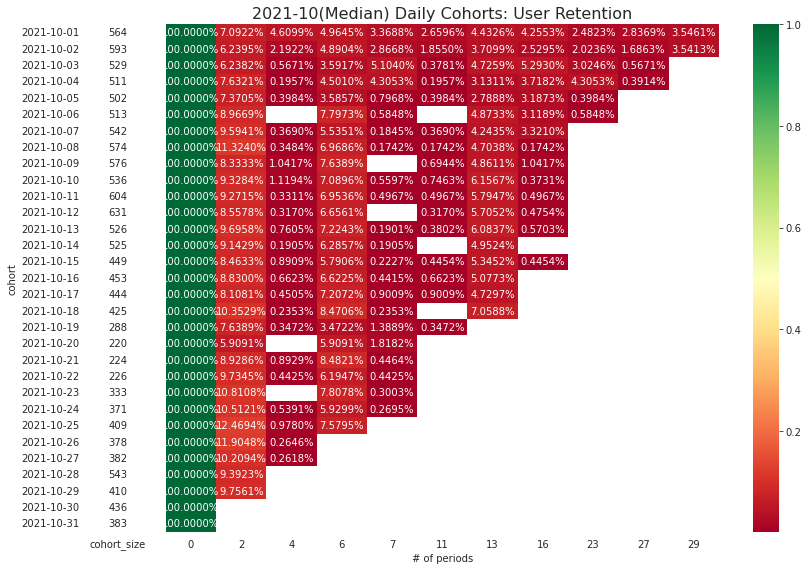

In [59]:
# visualize the retention rate
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.4%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('2021-10(Median) Daily Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [45]:
# choose data of November 2022
df_e['Day'] = pd.to_datetime(df_e['Day'], format="%Y/%m/%d")

open_day3='2020-11-01'

close_day3='2020-11-30'

con5=df_e['Day']>=open_day3

con6=df_e['Day']<=close_day3

df_e3=df_e[con5&con6]

In [46]:
# Get the cohort for each user 
df_e3['order_day'] = df_e3['Day'].dt.to_period('D')
df_e3['cohort'] = df_e3.groupby('Id')['Day'].transform('min') \
                 .dt.to_period('D') 
df_e3

,Id,Day,Spend,order_day,cohort
60,13,2020-11-03,4.033833,2020-11-03,2020-11-03
61,13,2020-11-05,0.080000,2020-11-05,2020-11-03
65,14,2020-11-03,0.122223,2020-11-03,2020-11-03
90,19,2020-11-28,0.748261,2020-11-28,2020-11-28
91,19,2020-11-30,0.539325,2020-11-30,2020-11-28
...,...,...,...,...,...
1461290,292259,2020-11-28,0.114986,2020-11-28,2020-11-28
1461295,292260,2020-11-28,0.034946,2020-11-28,2020-11-28
1461300,292261,2020-11-28,0.232864,2020-11-28,2020-11-28
1461301,292261,2020-11-30,0.933667,2020-11-30,2020-11-28


In [47]:
# Get the customer_number and period_number for each day
df_e3_cohort = df_e3.groupby(['cohort', 'order_day'])['Id'].nunique().reset_index()

df_e3_cohort.columns=['cohort', 'order_day', 'customer_number']
df_e3_cohort['period_number'] = (df_e3_cohort.order_day - df_e3_cohort.cohort).apply(attrgetter('n'))
df_e3_cohort

,cohort,order_day,customer_number,period_number
0,2020-11-01,2020-11-01,727,0
1,2020-11-01,2020-11-03,53,2
2,2020-11-01,2020-11-05,30,4
3,2020-11-01,2020-11-07,32,6
4,2020-11-01,2020-11-08,14,7
...,...,...,...,...
182,2020-11-27,2020-11-29,62,2
183,2020-11-28,2020-11-28,544,0
184,2020-11-28,2020-11-30,59,2
185,2020-11-29,2020-11-29,522,0


<AxesSubplot:xlabel='period_number', ylabel='customer_number'>

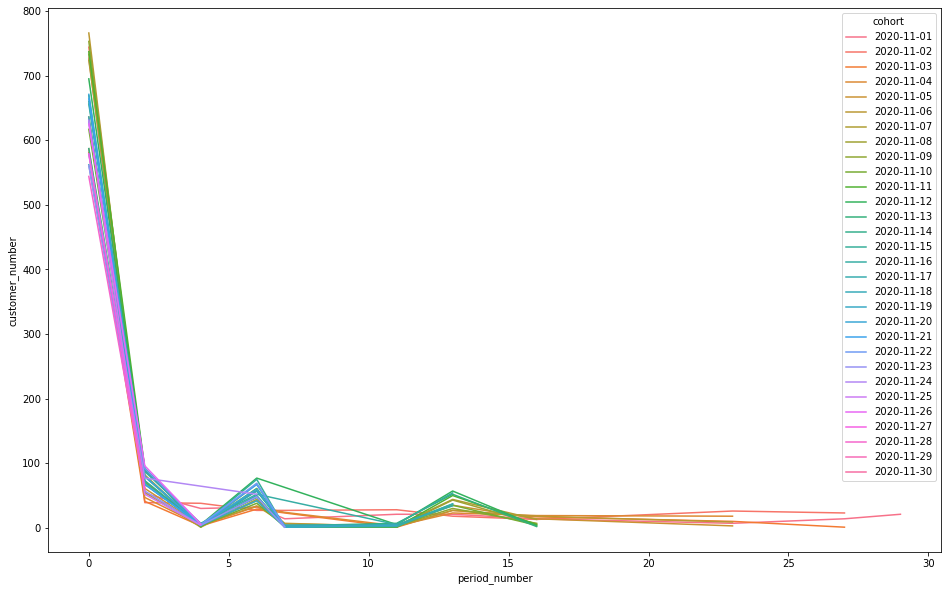

In [48]:
# Draw the line plot between customer_number and period_number
plt.subplots(figsize=(16,10))
sns.lineplot(data=df_e3_cohort,x='period_number',y='customer_number',hue='cohort')

In [49]:
# Build the pivot table for each cohort
cohort_pivot = df_e3_cohort.pivot_table(index = 'cohort',
                                       columns = 'period_number',
                                       values = 'customer_number')
cohort_pivot

period_number,0,2,4,6,7,11,13,16,23,27,29
cohort,,,,,,,,,,,
2020-11-01,727.0,53.0,30.0,32.0,14.0,21.0,21.0,14.0,7.0,14.0,21.0
2020-11-02,744.0,39.0,38.0,27.0,27.0,28.0,18.0,13.0,26.0,23.0,NaN
2020-11-03,581.0,41.0,3.0,29.0,23.0,1.0,27.0,17.0,10.0,1.0,NaN
2020-11-04,587.0,47.0,4.0,33.0,24.0,3.0,23.0,19.0,18.0,NaN,NaN
2020-11-05,636.0,61.0,4.0,34.0,6.0,3.0,35.0,14.0,3.0,NaN,NaN
2020-11-06,766.0,55.0,1.0,44.0,7.0,2.0,27.0,18.0,9.0,NaN,NaN
2020-11-07,724.0,82.0,2.0,58.0,2.0,3.0,44.0,13.0,NaN,NaN,NaN
2020-11-08,733.0,80.0,1.0,68.0,2.0,1.0,43.0,6.0,NaN,NaN,NaN
2020-11-09,753.0,70.0,4.0,42.0,2.0,3.0,30.0,7.0,NaN,NaN,NaN


In [50]:
# Calculate the cohort size
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0) 

cohort_size

cohort
2020-11-01    727.0
2020-11-02    744.0
2020-11-03    581.0
2020-11-04    587.0
2020-11-05    636.0
2020-11-06    766.0
2020-11-07    724.0
2020-11-08    733.0
2020-11-09    753.0
2020-11-10    617.0
2020-11-11    737.0
2020-11-12    695.0
2020-11-13    660.0
2020-11-14    587.0
2020-11-15    669.0
2020-11-16    656.0
2020-11-17    562.0
2020-11-18    636.0
2020-11-19    632.0
2020-11-20    671.0
2020-11-21    664.0
2020-11-22    628.0
2020-11-23    561.0
2020-11-24    578.0
2020-11-25    631.0
2020-11-26    625.0
2020-11-27    579.0
2020-11-28    544.0
2020-11-29    522.0
2020-11-30    532.0
Freq: D, Name: 0, dtype: float64

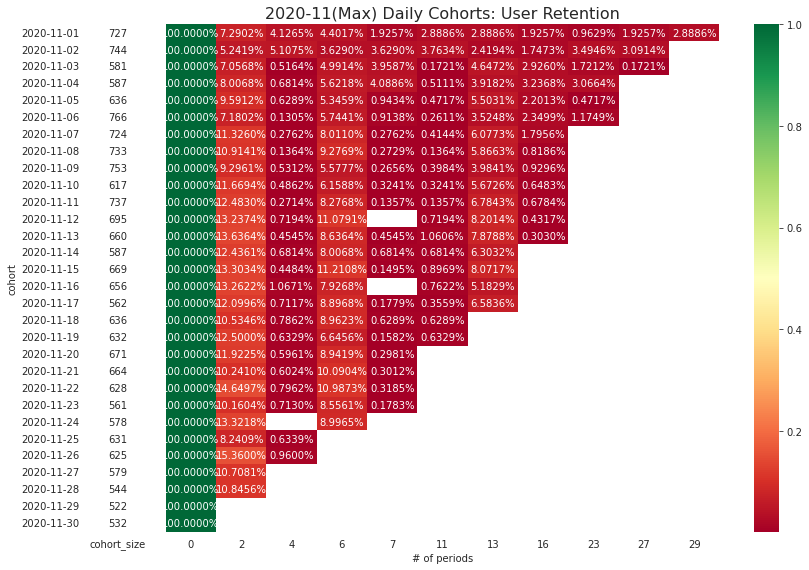

In [51]:
# visualize the retention rate
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.4%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('2020-11(Max) Daily Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

In [60]:
# extract data for acitivty p and fill all null values with 0
df_pcount = df[['count_p_1','count_p_7','count_p_8','count_p_9','count_p_10','count_p_11','count_p_12',
                'count_p_13','count_p_15','count_p_19','count_p_20']]
df_pcount = df_pcount.fillna(0)
df_pcount.head(10)

,count_p_1,count_p_7,count_p_8,count_p_9,count_p_10,count_p_11,count_p_12,count_p_13,count_p_15,count_p_19,count_p_20
0,72.0,72.0,72.0,72.0,0.0,0.0,32.0,3.0,27.0,1.0,0.0
1,40.0,40.0,40.0,40.0,0.0,3.0,1.0,0.0,19.0,1.0,2.0
2,3.0,0.0,3.0,3.0,1.0,4.0,5.0,0.0,37.0,5.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,8.0,1.0,0.0
4,18.0,18.0,18.0,18.0,2.0,0.0,2.0,0.0,4.0,1.0,0.0
5,22.0,22.0,22.0,22.0,0.0,2.0,6.0,0.0,11.0,2.0,1.0
6,3.0,0.0,3.0,3.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,12.0,1.0,0.0
8,10.0,10.0,10.0,10.0,0.0,2.0,8.0,0.0,4.0,1.0,0.0
9,4.0,4.0,4.0,4.0,0.0,2.0,7.0,0.0,7.0,1.0,0.0


In [61]:
# if the value of count_p >0, replace it with 1
df_pcount1 = df_pcount.copy()
df_pcount1[df_pcount1>0] = 1

df_pcount1.head(10)

,count_p_1,count_p_7,count_p_8,count_p_9,count_p_10,count_p_11,count_p_12,count_p_13,count_p_15,count_p_19,count_p_20
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
5,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
6,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
8,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
9,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


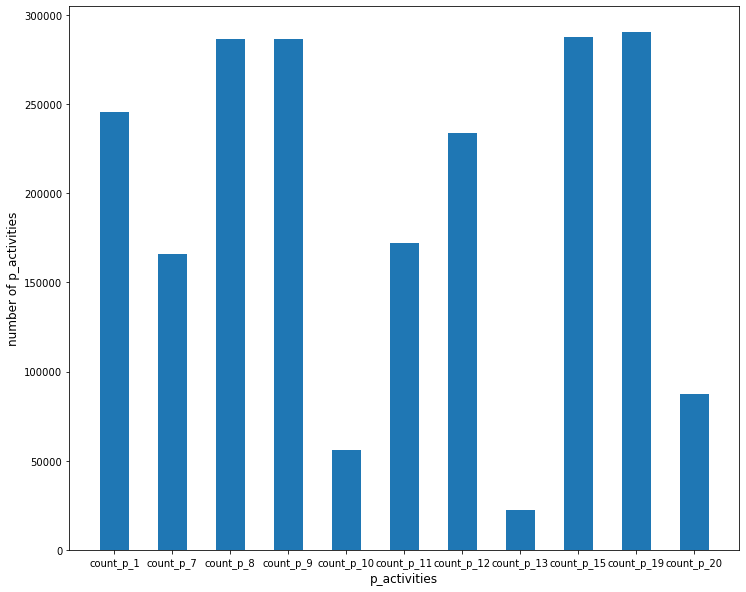

In [62]:
# visualize the number of users participate each activity
plt.figure(figsize=(12,10))

x = ['count_p_1','count_p_7','count_p_8','count_p_9','count_p_10','count_p_11','count_p_12','count_p_13',
    'count_p_15','count_p_19','count_p_20']
y = [df_pcount1['count_p_1'].sum(),df_pcount1['count_p_7'].sum(),df_pcount1['count_p_8'].sum(),df_pcount1['count_p_9'].sum(),
    df_pcount1['count_p_10'].sum(),df_pcount1['count_p_11'].sum(),df_pcount1['count_p_12'].sum(),df_pcount1['count_p_13'].sum(),
    df_pcount1['count_p_15'].sum(),df_pcount1['count_p_19'].sum(),df_pcount1['count_p_20'].sum()]

cm = plt.bar(x, y, width=0.5)

plt.xlabel("p_activities", size=12)
plt.ylabel("number of p_activities", size=12)

plt.show()
